In [1]:
import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

Using TensorFlow backend.


In [3]:

def parse_img_filepath(filepath):
    f = filepath.split('/')[-1]
    f = f[:-4] #remove ".jpg"
    f = f.split('_')

    throttle = round(float(f[3]), 2)
    angle = round(float(f[5]), 2)
    milliseconds = round(float(f[7]))

    data = {'throttle':throttle, 'angle':angle, 'milliseconds': milliseconds}
    return data

def load_frame(file_path):
    '''
    Retrieve an image and its telemetry data.
    '''

    with Image.open(file_path) as img:
        img_arr = np.array(img)

    data = parse_img_filepath(file_path)

    return img_arr, data

def frame_generator(img_paths):
    '''
    Generator that loops through image arrays and their telemetry data.
    '''
    while True:
        for f in img_paths:

            img_arr, data = load_frame(f)

            #return only angle for now
            data_arr = np.array([data['angle'], data['throttle']])
            yield img_arr, data_arr

def batch_generator(img_paths, batch_size=32):
    '''
    Generator that returns batches of X, Y data.
    '''
    frame_gen = frame_generator(img_paths)

    while True:

        X, Y = [], []
        for _ in range(batch_size):
            x, y = next(frame_gen)
            X.append(x)
            Y.append(y)

        X = np.array(X)
        Y = np.array(Y)

        yield X, Y

def load_dataset(img_paths):
    '''
    Returns image arrays and data arrays.

        X - array of n samples of immage arrays representing.
        Y - array with the shape (samples, 1) containing the
            angle lable for each image

        Where n is the number of recorded images.
    '''
    batch_gen = batch_generator(img_paths, batch_size=len(img_paths))
    X, Y = next(batch_gen)
    return X, Y

def img_paths(folder):
    """
    Returns a list of file paths for the images in the session.
    """
    files = os.listdir(folder)
    files = [f for f in files if f[-3:] =='jpg']
    files.sort()
    file_paths = [os.path.join(folder, f) for f in files]
    return file_paths

class Session():
    '''
    Class to store images and vehicle data to the local file system and later retrieve them
    as arrays or generators.
    '''

    def __init__(self, path):
        print('Loading Session: %s' %path)
        self.session_dir = path
        self.frame_count = 0

    def put(self, img, angle=None, throttle=None, milliseconds=None):

        '''
        Save image with encoded angle, throttle and time data in the filename
        '''
        self.frame_count += 1
        filepath = create_img_filepath(self.session_dir, self.frame_count, angle, throttle, milliseconds)
        img.save(filepath, 'jpeg')


    def get(self, file_path):
        '''
        Retrieve an image and the data saved with it.
        '''
        img_arr, data = load_frame(file_path)
        return img_arr, data

    def delete(self):
        '''
        Delete all data in this session
        '''
        import shutil
        shutil.rmtree(self.session_dir);

    def delete_3s(self):
        files = [f for f in os.listdir(self.session_dir) if os.path.isfile(os.path.join(self.session_dir, f))]
        files.sort()
        for f in files[-100:]: # for last 100 files - it is roughly 3s worth of duration
            os.remove(os.path.join(self.session_dir, f))

    def img_paths(self):
        """
        Returns a list of file paths for the images in the session.
        """
        imgs = img_paths(self.session_dir)
        return imgs


    def img_count(self):
        return len(self.img_paths())


    def load_dataset(self, angle_only=True):
        '''
        Returns image arrays and data arrays.

            X - array of n samples of immage arrays representing.
            Y - array with the shape (samples, 1) containing the
                angle lable for each image

            Where n is the number of recorded images.
        '''
        X, Y = load_dataset(self.img_paths())

        return X, Y


class SessionHandler():
    '''
    Convienience class to create and load sessions.
    '''


    def __init__(self, sessions_path):

        self.sessions_path = os.path.expanduser(sessions_path)


    def new(self, name=None):
        '''
        Create a new session
        '''

        path = self.make_session_dir(self.sessions_path, session_name=name)
        session = Session(path)
        return session


    def load(self, name):
        '''
        Load a session given it's name.
        '''
        path = os.path.join(self.sessions_path, name)
        session = Session(path)
        return session


    def last(self):
        '''
        Return the last created session.
        '''
        dirs = [ name for name in os.listdir(self.sessions_path) if os.path.isdir(os.path.join(self.sessions_path, name)) ]
        if not dirs:
            return None

        dirs.sort()
        path = os.path.join(self.sessions_path, dirs[-1])
        session = Session(path)
        return session


    def make_session_dir(self, base_path, session_name=None):
        '''
        Make a new dir with a given name. If name doesn't exist
        use the current date/time.
        '''

        base_path = os.path.expanduser(base_path)
        if session_name is None:
            session_dir_name = time.strftime('%Y_%m_%d__%H_%M_%S')
        else:
            session_dir_name = session_name

        print('Creating a new session directory: %s' %session_dir_name)

        session_full_path = os.path.join(base_path, session_dir_name)
        if not os.path.exists(session_full_path):
            os.makedirs(session_full_path)
        return session_full_path

def sessions_to_dataset(session_names):

    '''
    Combine, pickle and safe session data to a file.

    'sessions_folder' where the session folders reside
    'session_names' the names of the folders of the sessions to Combine
    'file_path' name of the pickled file that will be saved
    '''

    sh = SessionHandler('../../donkeycar/d2/sessions.oak')

    X = []
    Y = []

    for name in session_names:
        s = sh.load(name)
        if s.img_count() == 0:
            next
        x, y = s.load_dataset()
        X.append(x)
        Y.append(y)

    X = np.concatenate(X)
    Y = np.concatenate(Y)
    return X, Y

# ds = sessions_to_dataset(os.listdir('../../donkeycar/d2/sessions.oak'))
ds = sessions_to_dataset(['yellowline'])

Loading Session: ../../donkeycar/d2/sessions.oak/yellowline


In [6]:
def undistort_dataset(dataset):
    return (np.asarray([undistort(img, balance=0.6) for img in dataset[0]]), dataset[1])

ds = undistort_dataset(ds)

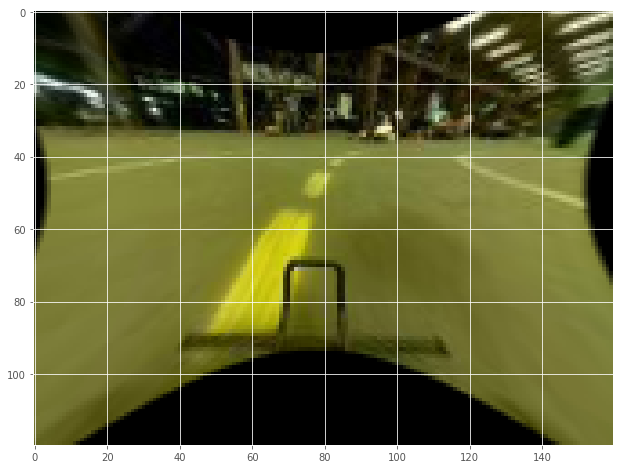

In [9]:
plt.imshow(ds[0][200])

In [8]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

def undistorted_ds(dataset):
    img_in = []
    for img in dataset[0]:
        img_in.append(undistort(img, balance=0.55)[9:79,:,:])
    
    return (np.asarray(img_in), dataset[1], dataset[2])

def mask_ds(dataset):
    mask_path = '../../donkeycar/d2/mask.png'
    mask = np.array(Image.open(mask_path))
    img_in = []
    for img in dataset[0]:
        img_in.append(utils.mask_image_array(img, mask))
    
    return (np.asarray(img_in), dataset[1], dataset[2])

import numpy as np
import os
import glob
import sys
import cv2


DIM=(1600, 1200)
K=np.array([[781.3524863867165, 0.0, 794.7118000552183], [0.0, 779.5071163774452, 561.3314451453386], [0.0, 0.0, 1.0]])
D=np.array([[-0.042595202508066574], [0.031307765215775184], [-0.04104704724832258], [0.015343014605793324]])

def undistort_maps(balance, w, h):
    assert w/h == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"

    scaled_K = K * w / DIM[0]
    scaled_K[2][2] = 1 # K[2][2] is always 1
    newmtx = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, (w,h), np.eye(3), balance=balance)
    return cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), newmtx, (w,h), cv2.CV_16SC2)

def undistort(img, map1, map2):
    return cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

Tub does exist


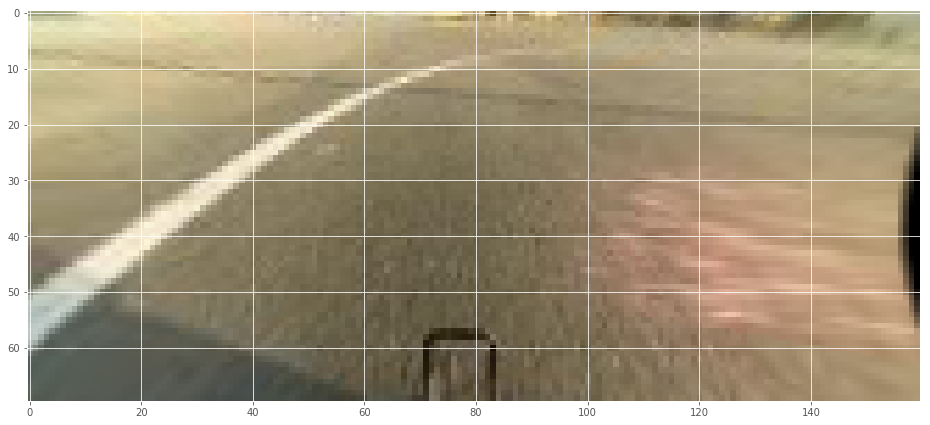

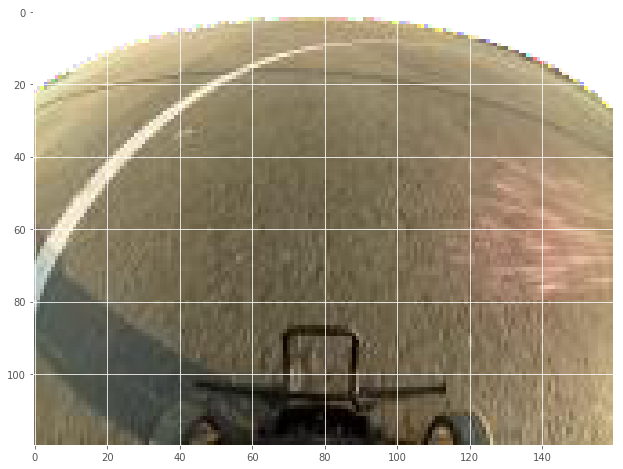

In [3]:
# dataset = dataset_from_all_tubs("../../donkeycar/d2/data")
dataset = dataset_from_tub("../../donkeycar/d2/data.ws.test/tub_notsogolden", limit=-1)
ds_70_160 = undistorted_ds(dataset)
plt.figure()
plt.imshow(ds_70_160[0][20])
masked_ds = mask_ds(dataset)
plt.figure()
plt.imshow(masked_ds[0][20])

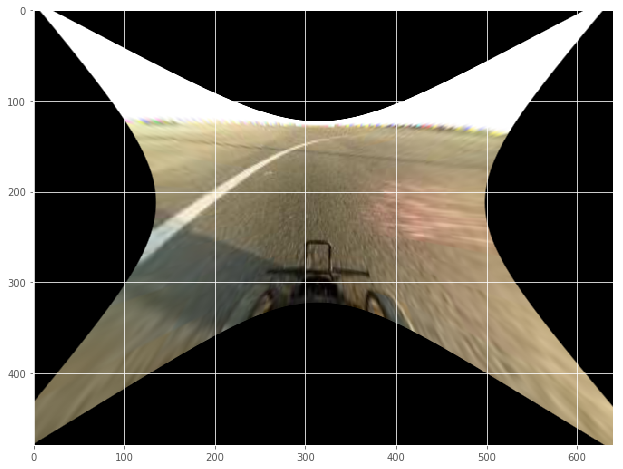

In [17]:
img = masked_ds[0][20]
img = cv2.resize(img, (0, 0), fx = 4, fy = 4, interpolation = cv2.INTER_LINEAR)
map1, map2 = undistort_maps(0.9,640,480)
img_out = undistort(img, map1, map2)
plt.imshow(img_out)

In [5]:
import numpy as np
import os
import glob
import sys
import cv2


DIM=(1600, 1200)
K=np.array([[781.3524863867165, 0.0, 794.7118000552183], [0.0, 779.5071163774452, 561.3314451453386], [0.0, 0.0, 1.0]])
D=np.array([[-0.042595202508066574], [0.031307765215775184], [-0.04104704724832258], [0.015343014605793324]])

def undistort_maps(img, balance):
    h,w = img.shape[:2]

    assert w/h == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"

    scaled_K = K * w / DIM[0]
    scaled_K[2][2] = 1 # K[2][2] is always 1
    newmtx = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, (w,h), np.eye(3), balance=balance)
    return cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), newmtx, (w,h), cv2.CV_16SC2)

def undistort(img, balance=0.0):
    map1, map2 = undistort_maps(img, balance)
    return cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# img = Image.open('../../donkeycar/d2/data/tub_44_17-09-15/154_cam-image_array_.jpg')
# img = img.resize((160*2, 120*2), resample=Image.LANCZOS)
img = Image.open('../../donkeycar/d2/pics/10d.jpg')
img = np.array(img)
# img = undistort(img, balance=0.97)
img = undistort(img, balance=0.70)
cv2.imwrite("../../donkeycar/d2/pics/10d_undistort.jpg", img)

True

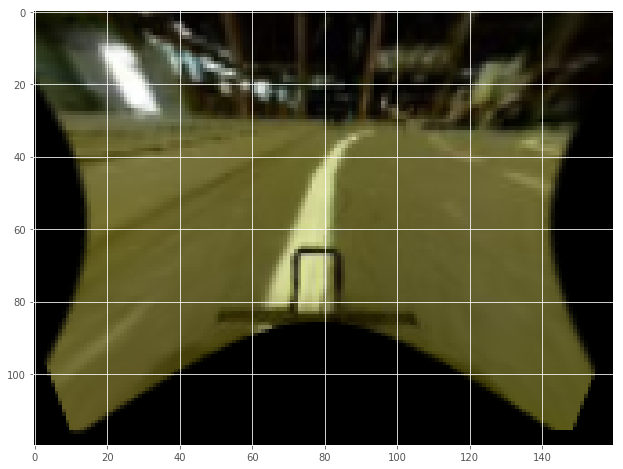

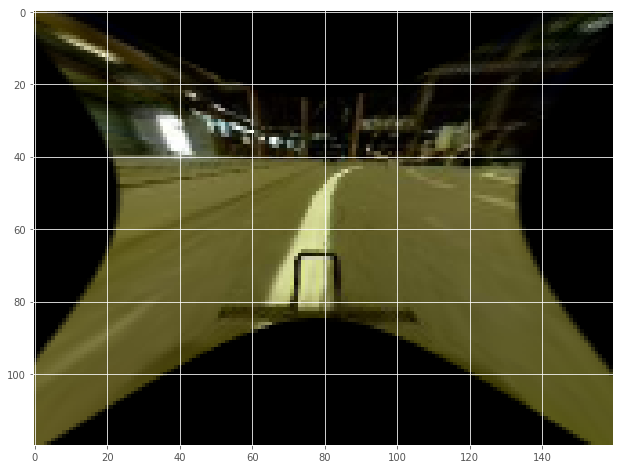

In [23]:
import numpy as np
import cv2

img = cv2.imread('../../donkeycar/_15degree1_undistort.jpg')

# These numbers are for old -> new perspective transform
src = np.array([(710,476), (853,479), (902,729), (661,724)], dtype = "float32")
dst = np.array([(696, 403), (870, 407), (910, 729), (653, 724)], dtype = "float32")
src = src/10
dst = dst/10
M = cv2.getPerspectiveTransform(src, dst)
img = np.asarray(Image.open('../../donkeycar/frame.jpg'))
img = undistort(img, balance=0.8)
img_out = cv2.warpPerspective(np.asarray(img), M, (160, 120))
plt.imshow(img_out)
plt.figure()
plt.imshow(img)

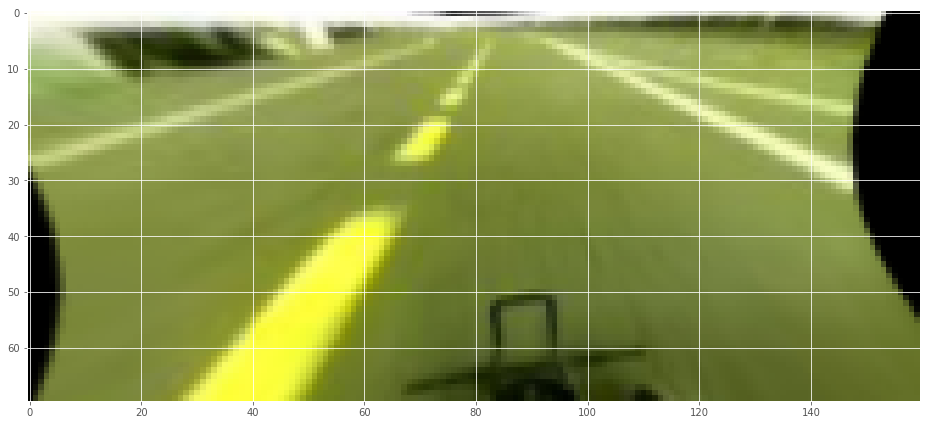

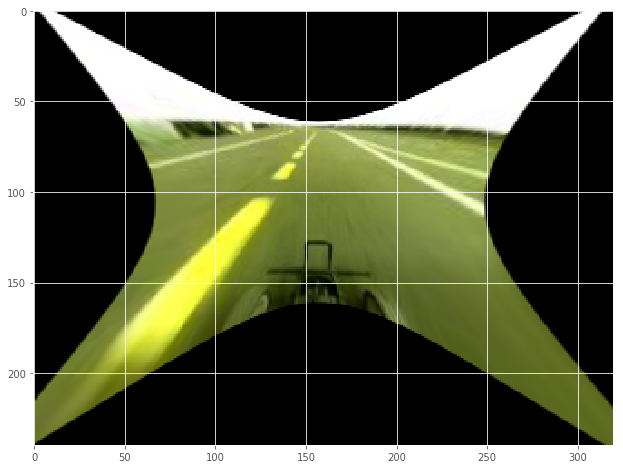

In [49]:
import numpy as np
import cv2

src = np.array([(661, 526), (872,523), (917,647), (623,658)], dtype = "float32")
dst = np.array([(609,541), (824,512), (877,625), (581,685)], dtype = "float32")
src = src/5
dst = dst/5
M = cv2.getPerspectiveTransform(src, dst)
img = np.asarray(Image.open('../../donkeycar/d2/pics/13_cam-image_array_.jpg'))
img = cv2.resize(img, (160*2, 120*2), interpolation=cv2.INTER_LINEAR)
img = np.asarray(img)
img = undistort(img, balance=0.9)

img_out = cv2.warpPerspective(img, M, (320, 240))
img_out = img_out[60:152, 34:244,:]
img_out = cv2.resize(img_out, (160,70), interpolation=cv2.INTER_LINEAR)
cv2.imwrite('../../donkeycar/d2/pics/out.jpg', img_out)
plt.imshow(img_out)

plt.figure()
plt.imshow(img)

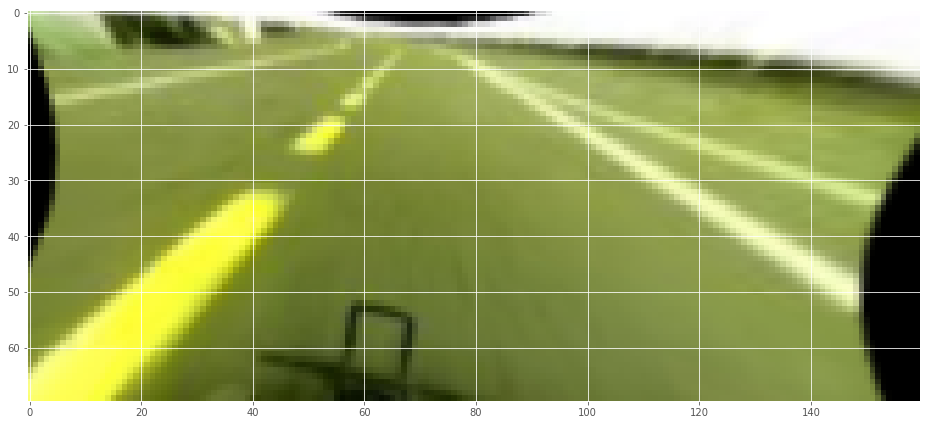

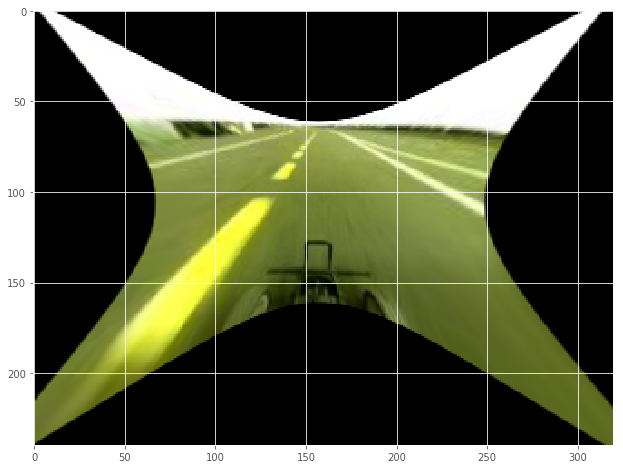

In [50]:
import numpy as np
import cv2

src = np.array([(661, 526), (872,523), (917,647), (623,658)], dtype = "float32")
dst = np.array([(609,541), (824,512), (877,625), (581,685)], dtype = "float32")
src = src/5
dst = dst/5
# M = cv2.getPerspectiveTransform(src, dst)
M = cv2.getPerspectiveTransform(dst,src)
img = np.asarray(Image.open('../../donkeycar/d2/pics/13_cam-image_array_.jpg'))
img = cv2.resize(img, (160*2, 120*2), interpolation=cv2.INTER_LINEAR)
img = np.asarray(img)
img = undistort(img, balance=0.9)

img_out = cv2.warpPerspective(img, M, (320, 240))
cv2.imwrite('../../donkeycar/d2/pics/out.jpg', img_out)
img_out = img_out[59:151, 81:291,:]
img_out = cv2.resize(img_out, (160,70), interpolation=cv2.INTER_LINEAR)
plt.imshow(img_out)

plt.figure()
plt.imshow(img)